# Interpretable Deep Learning for Automatic Diagnosis of 12-lead Electrocardiogram #
Zhang, D.; Yang, S.; Yuan, X.; Zhang, P. Interpretable deep learning for automatic diagnosis of 12-lead electrocardiogram. iScience 2021

# Course work
This jupyter notebook is part of my research as part of the coursework "ECG Classification of Arrhythmias based on deep learning." created by Vlasov Artyom, the student of Higher School of Economics. In addition to the original code files, the results of my model training are stored here.

### Limitations of the study
In this paper, we developed a deep neural network for automatic diagnosis of cardiac arrhythmias from 12-lead ECG recordings. The proposed model achieved state-of-the-art performance on the CPSC2018 dataset and employed the SHAP method to enhance clinical interpretability. However, model generalization to patients of different races should be further validated since the CPSC2018 dataset is entirely collected from China hospitals. Secondly, adversarial samples can lead to misbehaviors of deep learning models. It is crucial to test the model's robustness, protect from adversarial attacks, and avoid overoptimistic of the model. Besides, there is no objective gold standard for ECG interpretation. What combination of ECG leads could achieve better performance remains unexplored.

### Resource availability
Lead contact\
Ping Zhang, PhD, zhang.10631@osu.edu.
### Materials availability
This study did not generate any new materials.
### Data and code availability
The 12-lead ECG data set used in this study is the CPSC2018 training dataset which is released by the first China Physiological Signal Challenge (CPSC) 2018 during the seventh International Conference on Biomedical Engineering and Biotechnology. Details of the CPSC2018 dataset can be found at http://2018.icbeb.org/Challenge.html. The source code is provided and is available at https://github.com/onlyzdd/ecg-diagnosis.

In [ ]:
import argparse
import os
from glob import glob

import matplotlib.pyplot as plt
import wfdb
from tqdm import tqdm

import warnings

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np

import pywt

from biosppy import ecg, tools
import scipy

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier

import pickle
import shap

In [ ]:
# dataset.py


def scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1, X.shape[1]))
    myNoise = np.matmul(np.ones((X.shape[0], 1)), scalingFactor)
    return X * myNoise


def shift(sig, interval=20):
    for col in range(sig.shape[1]):
        offset = np.random.choice(range(-interval, interval))
        sig[:, col] += offset / 1000
    return sig


def transform(sig, train=False):
    if train:
        if np.random.randn() > 0.5: sig = scaling(sig)
        if np.random.randn() > 0.5: sig = shift(sig)
    return sig


class ECGDataset(Dataset):
    def __init__(self, phase, data_dir, label_csv, folds, leads):
        super(ECGDataset, self).__init__()
        self.phase = phase
        df = pd.read_csv(label_csv)
        df = df[df['fold'].isin(folds)]
        self.data_dir = data_dir
        self.labels = df
        self.leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        if leads == 'all':
            self.use_leads = np.where(np.in1d(self.leads, self.leads))[0]
        else:
            self.use_leads = np.where(np.in1d(self.leads, leads))[0]
        self.nleads = len(self.use_leads)
        self.classes = ['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE'] # список диагнозов
        self.n_classes = len(self.classes)
        self.data_dict = {}
        self.label_dict = {}

    def __getitem__(self, index: int):
        row = self.labels.iloc[index]
        patient_id = row['patient_id']
        ecg_data, _ = wfdb.rdsamp(os.path.join(self.data_dir, patient_id))
        ecg_data = transform(ecg_data, self.phase == 'train')
        nsteps, _ = ecg_data.shape
        ecg_data = ecg_data[-15000:, self.use_leads]
        result = np.zeros((15000, self.nleads)) # 30 s, 500 Hz
        result[-nsteps:, :] = ecg_data
        if self.label_dict.get(patient_id):
            labels = self.label_dict.get(patient_id)
        else:
            labels = row[self.classes].to_numpy(dtype=np.float32)
            self.label_dict[patient_id] = labels
        return torch.from_numpy(result.transpose()).float(), torch.from_numpy(labels).float()

    def __len__(self):
        return len(self.labels)

In [ ]:
# expert_features.py


def cal_entropy(coeff):
    coeff = pd.Series(coeff).value_counts()
    entropy = scipy.stats.entropy(coeff)
    return entropy / 10


def cal_statistics(signal):
    n5 = np.percentile(signal, 5)
    n25 = np.percentile(signal, 25)
    n75 = np.percentile(signal, 75)
    n95 = np.percentile(signal, 95)
    median = np.percentile(signal, 50)
    mean = np.mean(signal)
    std = np.std(signal)
    var = np.var(signal)
    return [n5, n25, n75, n95, median, mean, std, var]


def extract_lead_heart_rate(signal, sampling_rate):
    # extract heart rate for single-lead ECG: may return empty list
    rpeaks, = ecg.hamilton_segmenter(signal=signal, sampling_rate=sampling_rate)
    rpeaks, = ecg.correct_rpeaks(signal=signal, rpeaks=rpeaks, sampling_rate=sampling_rate, tol=0.05)
    _, heartrates = tools.get_heart_rate(beats=rpeaks, sampling_rate=500, smooth=True, size=3)
    return list(heartrates / 100) # divided by 100


def extract_heart_rates(ecg_data, sampling_rate=500):
    # extract heart rates using 12-lead since rpeaks can not be detected on some leads
    heartrates = []
    for signal in ecg_data.T:
        lead_heartrates = extract_lead_heart_rate(signal=signal, sampling_rate=sampling_rate)
        heartrates += lead_heartrates
    return cal_statistics(heartrates)


def extract_lead_features(signal):
    # extract expert features for single-lead ECGs: statistics, shannon entropy
    lead_features = cal_statistics(signal) # statistic of signal
    coeffs = pywt.wavedec(signal, 'db10', level=4)
    for coeff in coeffs:
        lead_features.append(cal_entropy(coeff)) # shannon entropy of coefficients
        lead_features += cal_statistics(coeff) # statistics of coefficients
    return lead_features


def extract_features(ecg_data, sampling_rate=500):
    # extract expert features for 12-lead ECGs
    # may include heart rates later
    all_features = []
    # comment out below line to extract heart rates
    # all_features += extract_heart_rates(ecg_data, sampling_rate=sampling_rate)
    for signal in ecg_data.T:
        all_features += extract_lead_features(signal)
    return all_features

In [ ]:
# utils.py


def split_data(seed=42):
    folds = range(1, 11)
    folds = np.random.RandomState(seed).permutation(folds)
    return folds[:8], folds[8:9], folds[9:]


def prepare_input(ecg_file: str):
    if ecg_file.endswith('.mat'):
        ecg_file = ecg_file[:-4]
    ecg_data, _ = wfdb.rdsamp(ecg_file)
    nsteps, nleads = ecg_data.shape
    ecg_data = ecg_data[-15000:, :]
    result = np.zeros((15000, nleads)) # 30 s, 500 Hz
    result[-nsteps:, :] = ecg_data
    return result.transpose()


def cal_scores(y_true, y_pred, y_score):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score)
    acc = accuracy_score(y_true, y_pred)
    return precision, recall, f1, auc, acc


def find_optimal_threshold(y_true, y_score):
    thresholds = np.linspace(0, 1, 100)
    f1s = [f1_score(y_true, y_score > threshold) for threshold in thresholds]
    return thresholds[np.argmax(f1s)]


def cal_f1(y_true, y_score, find_optimal):
    if find_optimal:
        thresholds = np.linspace(0, 1, 100)
    else:
        thresholds = [0.5]
    f1s = [f1_score(y_true, y_score > threshold) for threshold in thresholds]
    return np.max(f1s)


def cal_f1s(y_trues, y_scores, find_optimal=True):
    f1s = []
    for i in range(y_trues.shape[1]):
        f1 = cal_f1(y_trues[:, i], y_scores[:, i], find_optimal)
        f1s.append(f1)
    return np.array(f1s)


def cal_aucs(y_trues, y_scores):
    return roc_auc_score(y_trues, y_scores, average=None)

In [ ]:
# preprocess.py


def gen_reference_csv(data_dir, reference_csv):
    if not os.path.exists(reference_csv):
        recordpaths = glob(os.path.join(data_dir, '*.hea'))
        results = []
        for recordpath in recordpaths:
            patient_id = recordpath.split('/')[-1][:-4]
            _, meta_data = wfdb.rdsamp(recordpath[:-4])
            sample_rate = meta_data['fs']
            signal_len = meta_data['sig_len']
            age = meta_data['comments'][0]
            sex = meta_data['comments'][1]
            dx = meta_data['comments'][2]
            age = age[5:] if age.startswith('Age: ') else np.NaN
            sex = sex[5:] if sex.startswith('Sex: ') else 'Unknown'
            dx = dx[4:] if dx.startswith('Dx: ') else ''
            results.append([patient_id, sample_rate, signal_len, age, sex, dx])
        df = pd.DataFrame(data=results, columns=['patient_id', 'sample_rate', 'signal_len', 'age', 'sex', 'dx'])
        df.sort_values('patient_id').to_csv(reference_csv, index=None)


def gen_label_csv(label_csv, reference_csv, dx_dict, classes):
    if not os.path.exists(label_csv):
        results = []
        df_reference = pd.read_csv(reference_csv)
        for _, row in df_reference.iterrows():
            patient_id = row['patient_id']
            dxs = [dx_dict.get(code, '') for code in row['dx'].split(',')]
            labels = [0] * 9
            for idx, label in enumerate(classes):
                if label in dxs:
                    labels[idx] = 1
            results.append([patient_id] + labels)
        df = pd.DataFrame(data=results, columns=['patient_id'] + classes)
        n = len(df)
        folds = np.zeros(n, dtype=np.int8)
        for i in range(10):
            start = int(n * i / 10)
            end = int(n * (i + 1) / 10)
            folds[start:end] = i + 1
        df['fold'] = np.random.permutation(folds)
        columns = df.columns
        df['keep'] = df[classes].sum(axis=1)
        df = df[df['keep'] > 0]
        df[columns].to_csv(label_csv, index=None)


if __name__ == "__main__":
    leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    dx_dict = {
        '426783006': 'SNR', # Normal sinus rhythm
        '164889003': 'AF', # Atrial fibrillation
        '270492004': 'IAVB', # First-degree atrioventricular block
        '164909002': 'LBBB', # Left bundle branch block
        '713427006': 'RBBB', # Complete right bundle branch block
        '59118001': 'RBBB', # Right bundle branch block
        '284470004': 'PAC', # Premature atrial contraction
        '63593006': 'PAC', # Supraventricular premature beats
        '164884008': 'PVC', # Ventricular ectopics
        '429622005': 'STD', # ST-segment depression
        '164931005': 'STE', # ST-segment elevation
    }
    classes = ['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE']
    data_dir = "/kaggle/input/ecg-diagnosis/data/CPSC"
    reference_csv = os.path.join(data_dir, 'reference.csv')
    label_csv = os.path.join(data_dir, 'labels.csv')
    gen_reference_csv(data_dir, reference_csv)
    gen_label_csv(label_csv, reference_csv, dx_dict, classes)

In [ ]:
# Baselines.py
warnings.filterwarnings('ignore', category=FutureWarning)


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data-dir', type=str, default='data/CPSC', help='Data directory')
    parser.add_argument('--classifier', type=str, default='all', help='Classifier to use: LR, RF, LGB, or MLP')
    parser.add_argument('--seed', type=int, default=42, help='Seed to split data')
    return parser.parse_args()


def generate_features_csv(features_csv, data_dir, patient_ids):
    print('Generating expert features...')
    ecg_features = []
    for patient_id in tqdm(patient_ids):
        ecg_data, _ = wfdb.rdsamp(os.path.join(data_dir, patient_id))
        ecg_features.append(extract_features(ecg_data))
    df = pd.DataFrame(ecg_features, index=patient_ids)
    df.index.name = 'patient_id'
    df.to_csv(features_csv)
    return df


if __name__ == "__main__":
    classes = ['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE']
    classifier = "classifier LR"
    data_dir = "/kaggle/input/ecg-diagnosis/data/CPSC"
    features_csv = os.path.join(data_dir, 'features.csv')
    labels_csv = os.path.join(data_dir, 'labels.csv')

    df_labels = pd.read_csv(labels_csv)
    patient_ids = df_labels['patient_id'].tolist()
    if not os.path.exists(features_csv):
        df_X = generate_features_csv(features_csv, data_dir, patient_ids)
    else:
        df_X = pd.read_csv(features_csv)
    df_X = df_X.merge(df_labels[['patient_id', 'fold']], on='patient_id')

    train_folds, val_folds, test_folds = split_data(seed=42)
    feature_cols = df_X.columns[1:-1] # remove patient id and fold

    X_train = df_X[df_X['fold'].isin(train_folds)][feature_cols].to_numpy()
    X_val = df_X[df_X['fold'].isin(val_folds)][feature_cols].to_numpy()
    X_test = df_X[df_X['fold'].isin(test_folds)][feature_cols].to_numpy()

    y_train = df_labels[df_labels['fold'].isin(train_folds)][classes].to_numpy()
    y_val = df_labels[df_labels['fold'].isin(val_folds)][classes].to_numpy()
    y_test = df_labels[df_labels['fold'].isin(test_folds)][classes].to_numpy()

    if classifier == 'all':
        classifiers = ['LR', 'RF', 'LGB', 'MLP']
    else:
        classifiers = [classifier]

    for classifier in classifiers:
        # tune parameters
        if classifier == 'LR':
            model = LogisticRegression(solver='lbfgs', max_iter=1000)
        elif classifier == 'RF':
            model = RandomForestClassifier(n_estimators=300, max_depth=10)
        elif classifier == 'LGB':
            model = LGBMClassifier(n_estimators=100)
        else:
            model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500)
        if classifier != 'MLP':
            model = OneVsRestClassifier(model)

        print(f'Start training {classifier}...')
        model.fit(X_train, y_train)

        y_val_scores = model.predict_proba(X_val)
        y_test_scores = model.predict_proba(X_test)

        f1s = []
        thresholds = []
        print('Finding optimal thresholds on validation dataset...')

        for i in range(len(classes)):
            # find optimal threshold on validation dataset
            y_val_score = y_val_scores[:, i]
            threshold = find_optimal_threshold(y_val[:, i], y_val_score)
            # apply optimal threshold to test dataset
            y_test_score = y_test_scores[:, i]
            y_test_pred = y_test_score > threshold
            f1 = f1_score(y_test[:, i], y_test_pred)
            thresholds.append(threshold)
            f1s.append(f1)
        np.set_printoptions(precision=3)
        print(f'{classifier} F1s:', f1s)
        print('Avg F1:', np.mean(f1s))

Start training classifier LR...
Finding optimal thresholds on validation dataset...
classifier LR F1s: [0.5777777777777777, 0.7228070175438597, 0.4832214765100671, 0.7999999999999999, 0.852852852852853, 0.25490196078431376, 0.5920000000000001, 0.47252747252747257, 0.45]
Avg F1: 0.5784542842218161


In [ ]:
# resnet.py


class BasicBlock1d(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock1d, self).__init__()
        self.conv1 = nn.Conv1d(inplanes, planes, kernel_size=7, stride=stride, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=7, stride=1, padding=3, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet1d(nn.Module):
    def __init__(self, block, layers, input_channels=12, inplanes=64, num_classes=9):
        super(ResNet1d, self).__init__()
        self.inplanes = inplanes
        self.conv1 = nn.Conv1d(input_channels, self.inplanes, kernel_size=15, stride=2, padding=7, bias=False)
        self.bn1 = nn.BatchNorm1d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(BasicBlock1d, 64, layers[0])
        self.layer2 = self._make_layer(BasicBlock1d, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(BasicBlock1d, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(BasicBlock1d, 512, layers[3], stride=2)
        self.adaptiveavgpool = nn.AdaptiveAvgPool1d(1)
        self.adaptivemaxpool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(512 * block.expansion * 2, num_classes)
        self.dropout = nn.Dropout(0.2)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x1 = self.adaptiveavgpool(x)
        x2 = self.adaptivemaxpool(x)
        x = torch.cat((x1, x2), dim=1)
        x = x.view(x.size(0), -1)
        return self.fc(x)


def resnet18(**kwargs):
    model = ResNet1d(BasicBlock1d, [2, 2, 2, 2], **kwargs)
    return model


def resnet34(**kwargs):
    model = ResNet1d(BasicBlock1d, [3, 4, 6, 3], **kwargs)
    return model

In [ ]:
# main.py


# Создаём класс для подмены аргументов из командной строки
class Args:
    data_dir = "/kaggle/input/ecg-diagnosis/data/CPSC"
    leads = "all"
    use_gpu = True
    model_path = ''  # Или укажите путь к уже обученной модели
    seed = 42
    batch_size = 32
    num_workers = 4
    lr = 0.001
    epochs = 40
    resume = False  # Если хотите загрузить модель из model_path, установите в True
    phase = "train"  # Или 'test' для тестирования


def train(dataloader, net, args, criterion, epoch, scheduler, optimizer, device):
    print('Training epoch %d:' % epoch)
    net.train()
    running_loss = 0
    output_list, labels_list = [], []
    for _, (data, labels) in enumerate(tqdm(dataloader)):
        data, labels = data.to(device), labels.to(device)
        output = net(data)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        output_list.append(output.data.cpu().numpy())
        labels_list.append(labels.data.cpu().numpy())
    # scheduler.step()
    print('Loss: %.4f' % running_loss)


def evaluate(dataloader, net, args, criterion, device):
    print('Validating...')
    net.eval()
    running_loss = 0
    output_list, labels_list = [], []
    for _, (data, labels) in enumerate(tqdm(dataloader)):
        data, labels = data.to(device), labels.to(device)
        output = net(data)
        loss = criterion(output, labels)
        running_loss += loss.item()
        output = torch.sigmoid(output)
        output_list.append(output.data.cpu().numpy())
        labels_list.append(labels.data.cpu().numpy())

    print('Loss: %.4f' % running_loss)
    y_trues = np.vstack(labels_list)
    y_scores = np.vstack(output_list)
    f1s = cal_f1s(y_trues, y_scores)
    avg_f1 = np.mean(f1s)
    print('F1s:', f1s)
    print('Avg F1: %.4f' % avg_f1)

    if args.phase == 'train' and avg_f1 > args.best_metric:
        args.best_metric = avg_f1

        # Создаём папку models, если её нет
        os.makedirs(os.path.dirname(args.model_path), exist_ok=True)

        torch.save(net.state_dict(), args.model_path)
    else:
        aucs = cal_aucs(y_trues, y_scores)
        avg_auc = np.mean(aucs)
        print('AUCs:', aucs)
        print('Avg AUC: %.4f' % avg_auc)



if __name__ == "__main__":
    args = Args()
    args.best_metric = 0
    data_dir = os.path.normpath(args.data_dir)
    database = os.path.basename(data_dir)

    if not args.model_path:
        args.model_path = f'/kaggle/working//resnet34_{database}_{args.leads}_{args.seed}.pth'

    if args.use_gpu and torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = 'cpu'

    if args.leads == 'all':
        leads = 'all'
        nleads = 12
    else:
        leads = args.leads.split(',')
        nleads = len(leads)

    label_csv = os.path.join(data_dir, 'labels.csv')

    train_folds, val_folds, test_folds = split_data(seed=args.seed)
    train_dataset = ECGDataset('train', data_dir, label_csv, train_folds, leads)
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=True)
    val_dataset = ECGDataset('val', data_dir, label_csv, val_folds, leads)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers, pin_memory=True)
    test_dataset = ECGDataset('test', data_dir, label_csv, test_folds, leads)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers, pin_memory=True)
    net = resnet34(input_channels=nleads).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=args.lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.1)

    criterion = nn.BCEWithLogitsLoss()

    if args.phase == 'train':
        if args.resume:
            net.load_state_dict(torch.load(args.model_path, map_location=device))
        for epoch in range(args.epochs):
            train(train_loader, net, args, criterion, epoch, scheduler, optimizer, device)
            evaluate(val_loader, net, args, criterion, device)
    else:
        net.load_state_dict(torch.load(args.model_path, map_location=device))
        evaluate(test_loader, net, args, criterion, device)

Training epoch 0:


100%|██████████| 172/172 [00:55<00:00,  3.09it/s]


Loss: 63.6701
Validating...


100%|██████████| 22/22 [00:04<00:00,  5.29it/s]


Loss: 5.6477
F1s: [0.52  0.556 0.39  0.936 0.878 0.227 0.504 0.412 0.133]
Avg F1: 0.5062
Training epoch 1:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 40.3991
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.35it/s]


Loss: 4.3512
F1s: [0.645 0.754 0.701 0.958 0.908 0.451 0.577 0.76  0.343]
Avg F1: 0.6775
Training epoch 2:


100%|██████████| 172/172 [00:54<00:00,  3.18it/s]


Loss: 30.2253
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.53it/s]


Loss: 4.3631
F1s: [0.721 0.846 0.829 0.958 0.903 0.646 0.828 0.817 0.458]
Avg F1: 0.7784
Training epoch 3:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 24.8493
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.44it/s]


Loss: 3.3238
F1s: [0.696 0.935 0.807 0.958 0.905 0.655 0.82  0.768 0.52 ]
Avg F1: 0.7849
Training epoch 4:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 23.0186
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.47it/s]


Loss: 3.0513
F1s: [0.697 0.89  0.857 0.936 0.906 0.718 0.818 0.836 0.549]
Avg F1: 0.8009
Training epoch 5:


100%|██████████| 172/172 [00:54<00:00,  3.18it/s]


Loss: 21.9801
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.00it/s]


Loss: 3.1348
F1s: [0.699 0.925 0.859 0.958 0.905 0.656 0.847 0.825 0.682]
Avg F1: 0.8174
Training epoch 6:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 20.7074
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.41it/s]


Loss: 3.1602
F1s: [0.76  0.922 0.846 0.957 0.899 0.703 0.836 0.812 0.567]
Avg F1: 0.8114
AUCs: [0.945 0.986 0.975 0.999 0.982 0.937 0.981 0.962 0.938]
Avg AUC: 0.9671
Training epoch 7:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 19.7381
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.42it/s]


Loss: 3.0371
F1s: [0.775 0.934 0.83  0.917 0.91  0.809 0.839 0.819 0.585]
Avg F1: 0.8241
Training epoch 8:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 18.5223
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.52it/s]


Loss: 2.7880
F1s: [0.782 0.908 0.834 0.979 0.92  0.743 0.862 0.847 0.653]
Avg F1: 0.8365
Training epoch 9:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 18.1694
Validating...


100%|██████████| 22/22 [00:02<00:00,  7.83it/s]


Loss: 2.7610
F1s: [0.788 0.931 0.868 0.958 0.918 0.738 0.867 0.81  0.667]
Avg F1: 0.8385
Training epoch 10:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 18.0925
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.56it/s]


Loss: 2.9169
F1s: [0.75  0.938 0.854 0.957 0.913 0.754 0.829 0.833 0.627]
Avg F1: 0.8282
AUCs: [0.953 0.985 0.98  0.998 0.983 0.885 0.98  0.962 0.946]
Avg AUC: 0.9636
Training epoch 11:


100%|██████████| 172/172 [00:54<00:00,  3.18it/s]


Loss: 17.3979
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.41it/s]


Loss: 2.8622
F1s: [0.742 0.939 0.874 0.957 0.927 0.77  0.852 0.827 0.632]
Avg F1: 0.8355
AUCs: [0.952 0.986 0.984 0.999 0.988 0.938 0.983 0.965 0.947]
Avg AUC: 0.9714
Training epoch 12:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 16.5798
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.33it/s]


Loss: 2.8657
F1s: [0.738 0.918 0.861 0.96  0.912 0.775 0.85  0.828 0.696]
Avg F1: 0.8374
AUCs: [0.957 0.978 0.975 1.    0.984 0.934 0.972 0.961 0.947]
Avg AUC: 0.9675
Training epoch 13:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 16.4591
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.35it/s]


Loss: 2.6377
F1s: [0.749 0.925 0.883 0.96  0.917 0.761 0.865 0.836 0.696]
Avg F1: 0.8434
Training epoch 14:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 15.9511
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.12it/s]


Loss: 2.7891
F1s: [0.763 0.948 0.855 0.939 0.908 0.8   0.855 0.835 0.667]
Avg F1: 0.8410
AUCs: [0.955 0.987 0.982 0.999 0.986 0.939 0.969 0.962 0.948]
Avg AUC: 0.9699
Training epoch 15:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 14.9087
Validating...


100%|██████████| 22/22 [00:03<00:00,  7.02it/s]


Loss: 2.5141
F1s: [0.77  0.944 0.896 0.939 0.927 0.791 0.877 0.841 0.558]
Avg F1: 0.8382
AUCs: [0.954 0.985 0.984 0.999 0.986 0.958 0.98  0.971 0.941]
Avg AUC: 0.9730
Training epoch 16:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 15.2154
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.40it/s]


Loss: 2.7664
F1s: [0.767 0.954 0.893 0.957 0.913 0.745 0.855 0.844 0.615]
Avg F1: 0.8380
AUCs: [0.957 0.987 0.977 0.999 0.987 0.93  0.975 0.972 0.944]
Avg AUC: 0.9698
Training epoch 17:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 14.6287
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.36it/s]


Loss: 3.0308
F1s: [0.79  0.944 0.857 0.96  0.918 0.74  0.84  0.843 0.649]
Avg F1: 0.8379
AUCs: [0.955 0.988 0.985 1.    0.986 0.914 0.956 0.967 0.959]
Avg AUC: 0.9676
Training epoch 18:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 13.4085
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.37it/s]


Loss: 2.8835
F1s: [0.767 0.938 0.877 0.96  0.92  0.779 0.86  0.804 0.649]
Avg F1: 0.8392
AUCs: [0.952 0.987 0.981 1.    0.988 0.924 0.985 0.952 0.967]
Avg AUC: 0.9707
Training epoch 19:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 12.5501
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.46it/s]


Loss: 2.7445
F1s: [0.747 0.93  0.883 0.941 0.929 0.8   0.879 0.81  0.711]
Avg F1: 0.8479
Training epoch 20:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 12.2524
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.43it/s]


Loss: 2.7313
F1s: [0.771 0.935 0.865 0.96  0.93  0.797 0.842 0.843 0.683]
Avg F1: 0.8473
AUCs: [0.96  0.988 0.982 0.999 0.987 0.914 0.983 0.972 0.972]
Avg AUC: 0.9731
Training epoch 21:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 11.9845
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.40it/s]


Loss: 2.5299
F1s: [0.763 0.926 0.895 0.96  0.926 0.777 0.872 0.859 0.677]
Avg F1: 0.8506
Training epoch 22:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 11.0040
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.28it/s]


Loss: 2.6475
F1s: [0.774 0.938 0.882 0.96  0.915 0.817 0.852 0.823 0.636]
Avg F1: 0.8441
AUCs: [0.955 0.987 0.979 0.999 0.987 0.945 0.979 0.963 0.978]
Avg AUC: 0.9746
Training epoch 23:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 10.6488
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.20it/s]


Loss: 2.6961
F1s: [0.74  0.922 0.897 0.958 0.913 0.782 0.842 0.85  0.681]
Avg F1: 0.8429
AUCs: [0.954 0.988 0.978 1.    0.987 0.93  0.974 0.973 0.979]
Avg AUC: 0.9736
Training epoch 24:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 10.5573
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.23it/s]


Loss: 3.3859
F1s: [0.792 0.94  0.895 0.96  0.918 0.748 0.839 0.828 0.696]
Avg F1: 0.8462
AUCs: [0.951 0.987 0.984 0.999 0.986 0.91  0.976 0.971 0.961]
Avg AUC: 0.9695
Training epoch 25:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 10.3927
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.25it/s]


Loss: 2.7154
F1s: [0.757 0.943 0.876 0.941 0.918 0.797 0.867 0.851 0.68 ]
Avg F1: 0.8478
AUCs: [0.957 0.987 0.974 0.999 0.988 0.957 0.974 0.973 0.976]
Avg AUC: 0.9761
Training epoch 26:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 8.8698
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.37it/s]


Loss: 3.3580
F1s: [0.768 0.948 0.886 0.98  0.919 0.762 0.85  0.832 0.683]
Avg F1: 0.8475
AUCs: [0.961 0.989 0.981 1.    0.986 0.928 0.972 0.97  0.979]
Avg AUC: 0.9740
Training epoch 27:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 9.3850
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.22it/s]


Loss: 2.3846
F1s: [0.791 0.938 0.886 0.98  0.921 0.803 0.869 0.841 0.744]
Avg F1: 0.8635
Training epoch 28:


100%|██████████| 172/172 [00:54<00:00,  3.18it/s]


Loss: 7.7807
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.33it/s]


Loss: 3.5306
F1s: [0.727 0.94  0.864 0.98  0.907 0.803 0.872 0.854 0.745]
Avg F1: 0.8546
AUCs: [0.946 0.987 0.977 0.999 0.987 0.95  0.989 0.979 0.984]
Avg AUC: 0.9776
Training epoch 29:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 7.8263
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.44it/s]


Loss: 2.9126
F1s: [0.776 0.944 0.905 0.96  0.924 0.833 0.862 0.856 0.731]
Avg F1: 0.8656
Training epoch 30:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 6.6444
Validating...


100%|██████████| 22/22 [00:02<00:00,  7.61it/s]


Loss: 3.3889
F1s: [0.749 0.927 0.893 0.96  0.923 0.817 0.881 0.832 0.784]
Avg F1: 0.8630
AUCs: [0.951 0.984 0.979 0.999 0.988 0.943 0.983 0.968 0.991]
Avg AUC: 0.9763
Training epoch 31:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 6.0149
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.41it/s]


Loss: 3.0017
F1s: [0.781 0.938 0.895 0.98  0.916 0.816 0.86  0.874 0.8  ]
Avg F1: 0.8733
Training epoch 32:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 5.5477
Validating...


100%|██████████| 22/22 [00:02<00:00,  7.50it/s]


Loss: 3.2745
F1s: [0.759 0.936 0.886 0.957 0.907 0.797 0.877 0.866 0.732]
Avg F1: 0.8574
AUCs: [0.962 0.985 0.982 1.    0.987 0.948 0.987 0.973 0.972]
Avg AUC: 0.9772
Training epoch 33:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 6.0349
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.38it/s]


Loss: 3.9091
F1s: [0.75  0.938 0.871 0.98  0.932 0.78  0.833 0.85  0.698]
Avg F1: 0.8480
AUCs: [0.949 0.99  0.974 1.    0.987 0.93  0.97  0.974 0.971]
Avg AUC: 0.9717
Training epoch 34:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 5.1850
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.60it/s]


Loss: 3.4072
F1s: [0.778 0.939 0.853 0.96  0.919 0.817 0.847 0.89  0.618]
Avg F1: 0.8469
AUCs: [0.957 0.988 0.977 1.    0.987 0.952 0.977 0.979 0.971]
Avg AUC: 0.9763
Training epoch 35:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 4.1970
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.48it/s]


Loss: 3.2566
F1s: [0.767 0.948 0.884 0.96  0.921 0.826 0.872 0.874 0.762]
Avg F1: 0.8682
AUCs: [0.961 0.989 0.979 1.    0.987 0.955 0.985 0.978 0.991]
Avg AUC: 0.9806
Training epoch 36:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 3.9378
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.26it/s]


Loss: 3.6237
F1s: [0.767 0.943 0.868 0.98  0.922 0.808 0.879 0.862 0.727]
Avg F1: 0.8618
AUCs: [0.958 0.989 0.976 1.    0.988 0.96  0.969 0.97  0.978]
Avg AUC: 0.9763
Training epoch 37:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 3.9895
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.22it/s]


Loss: 3.7431
F1s: [0.772 0.936 0.872 0.98  0.92  0.824 0.887 0.875 0.744]
Avg F1: 0.8679
AUCs: [0.957 0.985 0.978 1.    0.99  0.956 0.984 0.981 0.991]
Avg AUC: 0.9802
Training epoch 38:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 3.6753
Validating...


100%|██████████| 22/22 [00:02<00:00,  8.48it/s]


Loss: 4.1510
F1s: [0.75  0.943 0.872 1.    0.897 0.814 0.881 0.853 0.714]
Avg F1: 0.8583
AUCs: [0.947 0.988 0.974 1.    0.98  0.943 0.965 0.975 0.978]
Avg AUC: 0.9722
Training epoch 39:


100%|██████████| 172/172 [00:53<00:00,  3.19it/s]


Loss: 3.2061
Validating...


100%|██████████| 22/22 [00:02<00:00,  7.94it/s]


Loss: 3.9384
F1s: [0.786 0.93  0.886 0.979 0.921 0.762 0.864 0.87  0.746]
Avg F1: 0.8605
AUCs: [0.944 0.986 0.98  1.    0.987 0.936 0.969 0.977 0.991]
Avg AUC: 0.9745


In [ ]:
# predict.py


# Создаём класс для подмены аргументов из командной строки
class Args:
    data_dir = "/kaggle/input/ecg-diagnosis/data/CPSC"
    leads = "all"
    use_gpu = True
    model_path = ''  # Или укажите путь к уже обученной модели
    seed = 42
    batch_size = 32
    num_workers = 4
    lr = 0.001
    epochs = 20
    resume = False  # Если хотите загрузить модель из model_path, установите в True
    phase = "train"  # Или 'test' для тестирования


def get_thresholds(val_loader, net, device, threshold_path):
    print('Finding optimal thresholds...')
    if os.path.exists(threshold_path):
        return pickle.load(open(threshold_path, 'rb'))
    output_list, label_list = [], []
    for _, (data, label) in enumerate(tqdm(val_loader)):
        data, labels = data.to(device), label.to(device)
        output = net(data)
        output = torch.sigmoid(output)
        output_list.append(output.data.cpu().numpy())
        label_list.append(labels.data.cpu().numpy())
    y_trues = np.vstack(label_list)
    y_scores = np.vstack(output_list)
    thresholds = []
    for i in range(y_trues.shape[1]):
        y_true = y_trues[:, i]
        y_score = y_scores[:, i]
        threshold = find_optimal_threshold(y_true, y_score)
        thresholds.append(threshold)
    # pickle.dump(thresholds, open(threshold_path, 'wb'))
    return thresholds


def apply_thresholds(test_loader, net, device, thresholds):
    output_list, label_list = [], []
    for _, (data, label) in enumerate(tqdm(test_loader)):
        data, labels = data.to(device), label.to(device)
        output = net(data)
        output = torch.sigmoid(output)
        output_list.append(output.data.cpu().numpy())
        label_list.append(labels.data.cpu().numpy())
    y_trues = np.vstack(label_list)
    y_scores = np.vstack(output_list)
    y_preds = []
    scores = []
    for i in range(len(thresholds)):
        y_true = y_trues[:, i]
        y_score = y_scores[:, i]
        y_pred = (y_score >= thresholds[i]).astype(int)
        scores.append(cal_scores(y_true, y_pred, y_score))
        y_preds.append(y_pred)
    y_preds = np.array(y_preds).transpose()
    scores = np.array(scores)
    print('Precisions:', scores[:, 0])
    print('Recalls:', scores[:, 1])
    print('F1s:', scores[:, 2])
    print('AUCs:', scores[:, 3])
    print('Accs:', scores[:, 4])
    print(np.mean(scores, axis=0))
    plot_cm(y_trues, y_preds)


def plot_cm(y_trues, y_preds, normalize=True, cmap=plt.cm.Blues):
    classes = ['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE']
    for i, label in enumerate(classes):
        y_true = y_trues[:, i]
        y_pred = y_preds[:, i]
        cm = confusion_matrix(y_true, y_pred)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig, ax = plt.subplots(figsize=(4, 4))
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=[0, 1], yticklabels=[0, 1],
           title=label,
           ylabel='True label',
           xlabel='Predicted label')
        plt.setp(ax.get_xticklabels(), ha="center")

        fmt = '.3f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        np.set_printoptions(precision=3)
        fig.tight_layout()
        plt.savefig(f'/kaggle/working/{label}.png')
        plt.close(fig)


if __name__ == "__main__":
    args = Args()
    data_dir = os.path.normpath(args.data_dir)
    database = os.path.basename(data_dir)
    if not args.model_path:
        args.model_path = f'/kaggle/working/resnet34_{database}_{args.leads}_{args.seed}.pth'
    args.threshold_path = f'/kaggle/working/{database}-threshold.pkl'
    if args.use_gpu and torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = 'cpu'

    if args.leads == 'all':
        leads = 'all'
        nleads = 12
    else:
        leads = args.leads.split(',')
        nleads = len(leads)
    data_dir = args.data_dir
    label_csv = os.path.join(data_dir, 'labels.csv')

    net = resnet34(input_channels=nleads).to(device)
    net.load_state_dict(torch.load(args.model_path, map_location=device))
    net.eval()

    train_folds, val_folds, test_folds = split_data(seed=args.seed)
    train_dataset = ECGDataset('train', data_dir, label_csv, train_folds, leads)
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=True)
    val_dataset = ECGDataset('val', data_dir, label_csv, val_folds, leads)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers, pin_memory=True)
    test_dataset = ECGDataset('test', data_dir, label_csv, test_folds, leads)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers, pin_memory=True)

    thresholds = get_thresholds(val_loader, net, device, args.threshold_path)
    print('Thresholds:', thresholds)

    print('Results on validation data:')
    apply_thresholds(val_loader, net, device, thresholds)

    print('Results on test data:')
    apply_thresholds(test_loader, net, device, thresholds)

Finding optimal thresholds...


100%|██████████| 22/22 [00:02<00:00,  7.54it/s]


Thresholds: [0.23232323232323235, 0.9191919191919192, 0.3535353535353536, 0.7676767676767677, 0.9494949494949496, 0.08080808080808081, 0.4747474747474748, 0.04040404040404041, 0.9494949494949496]
Results on validation data:


100%|██████████| 22/22 [00:02<00:00,  8.43it/s]


Precisions: [0.752 0.943 0.907 0.96  0.921 0.769 0.867 0.861 0.941]
Recalls: [0.812 0.934 0.883 1.    0.911 0.87  0.852 0.888 0.696]
F1s: [0.781 0.938 0.895 0.98  0.916 0.816 0.86  0.874 0.8  ]
AUCs: [0.96  0.989 0.983 1.    0.989 0.955 0.981 0.977 0.994]
Accs: [0.933 0.981 0.977 0.999 0.956 0.961 0.975 0.964 0.988]
[0.88  0.872 0.873 0.981 0.97 ]
Results on test data:


100%|██████████| 22/22 [00:04<00:00,  5.24it/s]


Precisions: [0.67  0.947 0.908 0.875 0.908 0.722 0.797 0.747 0.667]
Recalls: [0.859 0.913 0.908 0.955 0.935 0.881 0.846 0.812 0.174]
F1s: [0.753 0.93  0.908 0.913 0.921 0.794 0.821 0.778 0.276]
AUCs: [0.969 0.993 0.99  0.998 0.989 0.985 0.946 0.979 0.968]
Accs: [0.93  0.972 0.977 0.994 0.961 0.961 0.965 0.946 0.969]
[0.805 0.809 0.788 0.98  0.964]


| CA type | Precision | Recall | F1   | AUC  | Accuracy |
|---------|-----------|--------|------|------|----------|
| SNR     | 0.67    | 0.859  | 0.753  | 0.969  | 0.93      |
| AF      | 0.947    | 0.913  | 0.93   | 0.993  | 0.972     |
| IAVB    | 0.908     | 0.908  | 0.908  | 0.99   | 0.977     |
| LBBB    | 0.875    | 0.955  | 0.913  | 0.998  | 0.994     |
| RBBB    | 0.908     | 0.935  | 0.921  | 0.989  | 0.961     |
| PAC     | 0.722     | 0.881  | 0.794  | 0.985  | 0.961     |
| PVC     | 0.797     | 0.846  | 0.821  | 0.946  | 0.965     |
| STD     | 0.747     | 0.812  | 0.778  | 0.979  | 0.946     |
| STE     | 0.667     | 0.174  | 0.276 | 0.968 | 0.969    |
| AVG     | 0.805     | 0.809  | 0.788 | 0.98 | 0.964    |

### Результаты

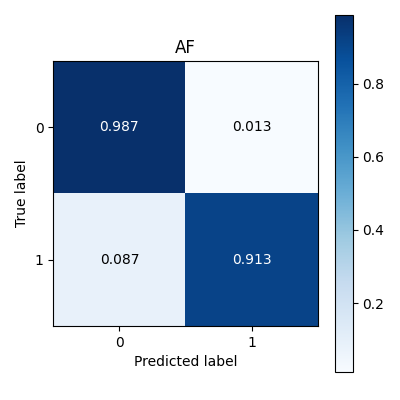

In [22]:
from IPython.display import Image
Image(filename='/kaggle/working/AF.png')

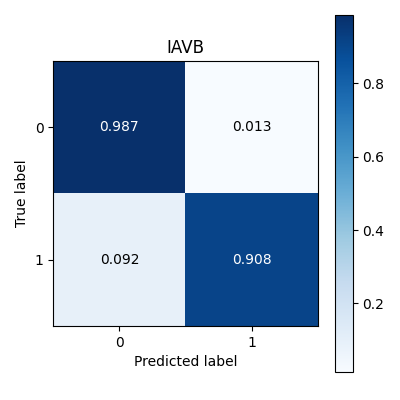

In [24]:
Image(filename='/kaggle/working/IAVB.png')

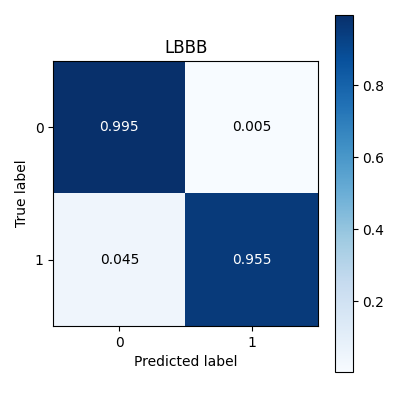

In [25]:
Image(filename='/kaggle/working/LBBB.png')

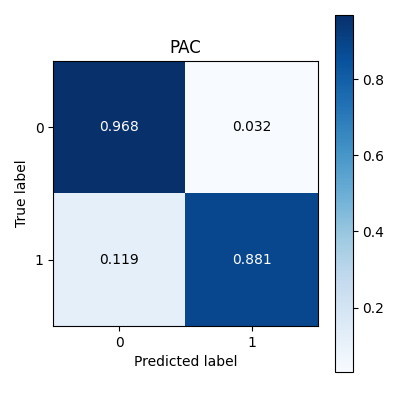

In [26]:
Image(filename='/kaggle/working/PAC.png')

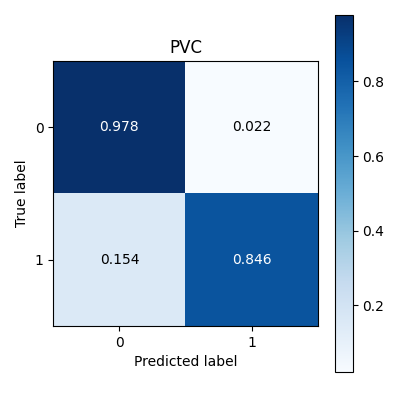

In [27]:
Image(filename='/kaggle/working/PVC.png')

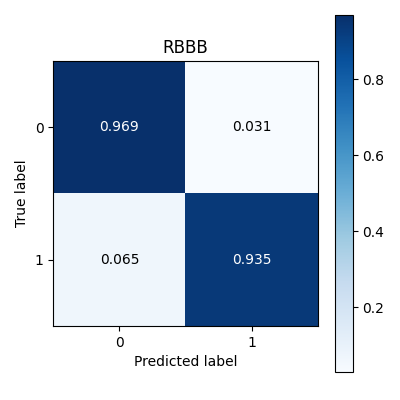

In [28]:
Image(filename='/kaggle/working/RBBB.png')

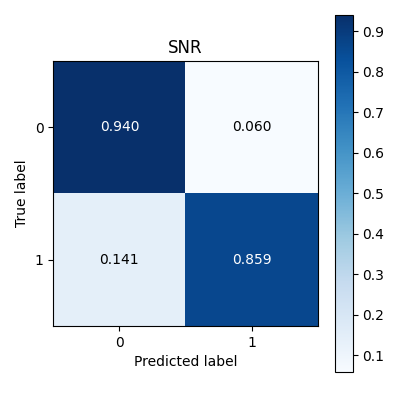

In [29]:
Image(filename='/kaggle/working/SNR.png')

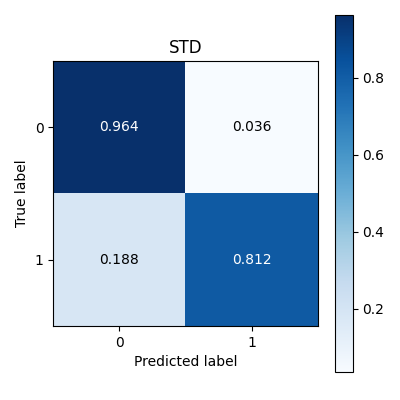

In [30]:
Image(filename='/kaggle/working/STD.png')

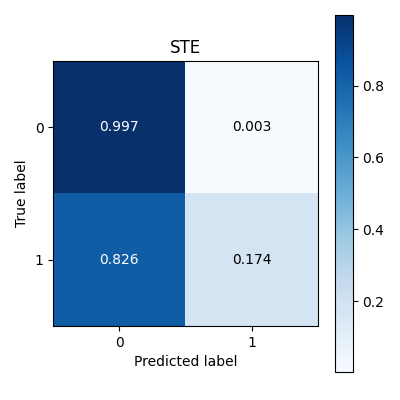

In [31]:
Image(filename='/kaggle/working/STE.png')

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Artvl\AppData\Local\Temp\ipykernel_8504\2728143158.py:2: SyntaxWarning: invalid escape sequence '\s'
  Image(filename='[110]\shap\shap2.png')


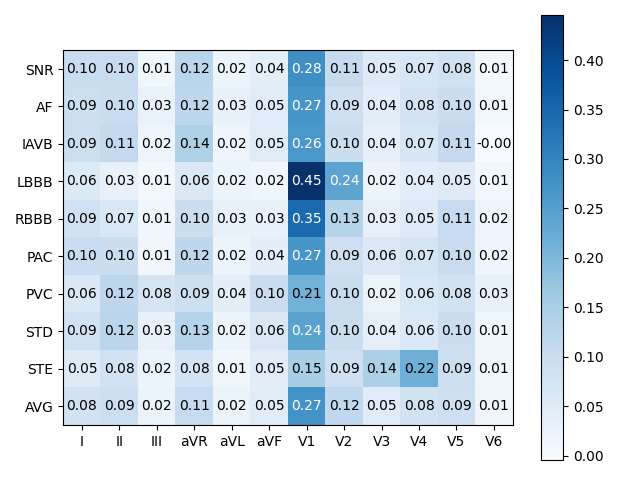

In [ ]:
Image(filename='[110]\shap\shap2.png')

100%|██████████| 200/200 [00:00<00:00, 5419.49it/s]


(9, 200, 12, 15000)


100%|██████████| 200/200 [00:00<00:00, 138677.60it/s]


A0001 RBBB ['V1' 'V2' 'V5']
A0001 — копия RBBB ['I' 'V1' 'V2' 'V5']
A0002 SNR ['V1']
A0003 AF ['I' 'aVR' 'V1' 'V2' 'V4' 'V5']
A0004 AF ['aVR' 'V1' 'V2' 'V4' 'V5']
A0005 PVC ['V2']
A0006 RBBB ['V1' 'V2' 'V5']
A0007 AF ['V1' 'V2' 'V5']
A0008 STD ['II' 'aVR' 'V1' 'V5']
A0009 AF ['II' 'aVR' 'V1' 'V2']
A0010 RBBB ['I' 'V1' 'V2']
A0011 LBBB ['V1' 'V2']
A0012 PVC ['II' 'III' 'aVF' 'V1']
A0013 STD ['I' 'II' 'aVR' 'aVF' 'V1' 'V5']
A0014 STD ['V1']
A0015 RBBB ['I' 'II' 'aVR' 'V1' 'V2' 'V5']
A0016 SNR ['aVR' 'V1']
A0017 AF ['I' 'II' 'III' 'aVR' 'aVF' 'V1' 'V5']
A0018 LBBB ['V1' 'V3' 'V4' 'V5']
A0019 AF ['II' 'aVR' 'V1' 'V2' 'V4']
A0020 SNR ['V1' 'V5']
A0021 STE ['V1' 'V4']
A0022 RBBB ['V1' 'V2' 'V3' 'V4' 'V5']
A0023 AF ['I' 'aVR' 'V1' 'V2' 'V5']
A0024 PVC ['III' 'V1']
A0025 PVC ['II' 'V1']
A0026 AF ['I' 'II' 'aVR']
A0027 RBBB ['V1']
A0028 RBBB ['V1' 'V2' 'V5']
A0029 SNR ['II' 'aVR' 'V1' 'V2']
A0030 SNR ['I' 'II' 'aVR' 'V1' 'V2']
A0031 PVC ['V1']
A0032 STE ['V3' 'V4']
A0033 STD ['V1']
A0034 STE ['

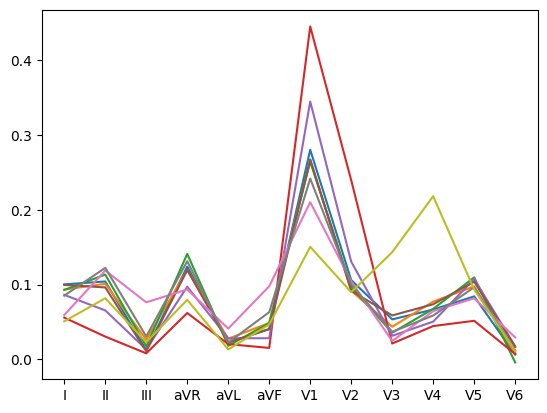

<Figure size 640x480 with 0 Axes>

In [ ]:
# shape_values.py


def plot_shap(ecg_data, sv_data, top_leads, patient_id, label):
    # patient-level interpretation along with raw ECG data
    leads = np.array(['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
    nleads = len(top_leads)
    if nleads == 0:
        return
    nsteps = 5000 # ecg_data.shape[1], visualize last 10 s since many patients' ECG are <=10 s
    x = range(nsteps)
    ecg_data = ecg_data[:, -nsteps:]
    sv_data = sv_data[:, -nsteps:]
    threshold = 0.001 # set threshold to highlight features with high shap values
    fig, axs = plt.subplots(nleads, figsize=(9, nleads))
    fig.suptitle(label)
    for i, lead in enumerate(top_leads):
        sv_upper = np.ma.masked_where(sv_data[lead] >= threshold, ecg_data[lead])
        sv_lower = np.ma.masked_where(sv_data[lead] < threshold, ecg_data[lead])
        if nleads == 1:
            axe = axs
        else:
            axe = axs[i]
        axe.plot(x, sv_upper, x, sv_lower)
        axe.set_xticks([])
        axe.set_yticks([])
        axe.set_ylabel(leads[lead])
    plt.savefig(f'/kaggle/working/shap1-{patient_id}.png')
    plt.close(fig)


def summary_plot(svs, y_scores):
    leads = np.array(['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
    svs2 = []
    n = y_scores.shape[0]
    for i in tqdm(range(n)):
        label = np.argmax(y_scores[i])
        sv_data = svs[label, i]
        svs2.append(np.sum(sv_data, axis=1))
    svs2 = np.vstack(svs2)
    svs_data = np.mean(svs2, axis=0)
    plt.plot(leads, svs_data)
    plt.savefig('/kaggle/working/summary.png')
    plt.clf()


def plot_shap2(svs, y_scores, cmap=plt.cm.Blues):
    # population-level interpretation
    leads = np.array(['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
    n = y_scores.shape[0]
    results = [[], [], [], [], [], [], [], [], []]
    print(svs.shape)
    for i in tqdm(range(n)):
        label = np.argmax(y_scores[i])
        results[label].append(svs[label, i])
    ys = []
    for label in range(y_scores.shape[1]):
        result = np.array(results[label])
        y = []
        for i, _ in enumerate(leads):
            y.append(result[:,i].sum())
        y = np.array(y) / np.sum(y)
        ys.append(y)
        plt.plot(leads, y)
    ys.append(np.array(ys).mean(axis=0))
    ys = np.array(ys)
    fig, axs = plt.subplots()
    im = axs.imshow(ys, cmap=cmap)
    axs.figure.colorbar(im, ax=axs)
    fmt = '.2f'
    xlabels = leads
    ylabels = ['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE'] + ['AVG']
    axs.set_xticks(np.arange(len(xlabels)))
    axs.set_yticks(np.arange(len(ylabels)))
    axs.set_xticklabels(xlabels)
    axs.set_yticklabels(ylabels)
    thresh = ys.max() / 2
    for i in range(ys.shape[0]):
        for j in range(ys.shape[1]):
            axs.text(j, i, format(ys[i, j], fmt),
                    ha='center', va='center',
                    color='white' if ys[i, j] > thresh else 'black')
    np.set_printoptions(precision=2)
    fig.tight_layout()
    plt.savefig('/kaggle/working/shap2.png')
    plt.clf()
    

if __name__ == '__main__':
    # Настраиваем параметры, загружаем модель и данные
    args = Args()
    data_dir = os.path.normpath(args.data_dir)
    database = os.path.basename(data_dir)
    args.model_path = f'/kaggle/working/resnet34_{database}_{args.leads}_{args.seed}.pth'
    label_csv = os.path.join(data_dir, 'labels.csv')
    reference_csv = os.path.join(data_dir, 'reference.csv')
    lleads = np.array(['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
    classes = np.array(['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE'])
    if args.use_gpu and torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = 'cpu'
    if args.leads == 'all':
        leads = 'all'
        nleads = 12
    else:
        leads = args.leads.split(',')
        nleads = len(leads)
    
    model = resnet34(input_channels=nleads).to(device)
    model.load_state_dict(torch.load(args.model_path, map_location=device))
    model.eval()

    # Готовит входные данные для SHAP
    background = 100
    result_path = f'/kaggle/working/A{background * 2}.npy'

    df_labels = pd.read_csv(label_csv)
    df_reference = pd.read_csv(os.path.join(args.data_dir, 'reference.csv'))
    df = pd.merge(df_labels, df_reference[['patient_id', 'age', 'sex', 'signal_len']], on='patient_id', how='left')

    # df = df[df['signal_len'] >= 15000]
    """Вычисляет SHAP-значения:
        1. Для каждого пациента:
        2. Загружает сигнал.
        3. Пропускает через модель, получая предсказание.
        4. Вычисляет SHAP-значения.
        5. Сохраняет их в файл A200.npy"""

    patient_ids = df['patient_id'].to_numpy()
    to_explain = patient_ids[:background * 2]

    background_patient_ids = df.head(background)['patient_id'].to_numpy()
    background_inputs = [os.path.join(data_dir, patient_id) for patient_id in background_patient_ids]
    background_inputs = torch.stack([torch.from_numpy(prepare_input(input)).float() for input in background_inputs]).to(device)
    
    e = shap.GradientExplainer(model, background_inputs)

    if not os.path.exists(result_path):
        svs = []
        y_scores = []
        for patient_id in tqdm(to_explain):
            input = os.path.join(data_dir, patient_id)
            inputs = torch.stack([torch.from_numpy(prepare_input(input)).float()]).to(device)
            y_scores.append(torch.sigmoid(model(inputs)).detach().cpu().numpy())
            sv = np.array(e.shap_values(inputs)) # (n_classes, n_samples, n_leads, n_points)
            svs.append(sv)
        svs = np.concatenate(svs, axis=1)
        y_scores = np.concatenate(y_scores, axis=0)
        np.save(result_path, np.array([svs, y_scores], dtype=object))
    svs, y_scores = np.load(result_path, allow_pickle=True)

    summary_plot(svs, y_scores)
    plot_shap2(svs, y_scores)

    preds = []
    top_leads_list = []
    for i, patient_id in enumerate(to_explain):
        ecg_data = prepare_input(os.path.join(data_dir, patient_id))
        label_idx = np.argmax(y_scores[i])
        sv_data = svs[label_idx, i]
        
        sv_data_mean = np.mean(sv_data, axis=1)
        top_leads = np.where(sv_data_mean > 1e-4)[0] # select top leads
        preds.append(classes[label_idx])
        print(patient_id, classes[label_idx], lleads[top_leads])

        plot_shap(ecg_data, sv_data, top_leads, patient_id, classes[label_idx])

### ECG analysis results

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Artvl\AppData\Local\Temp\ipykernel_8504\3129659795.py:1: SyntaxWarning: invalid escape sequence '\s'
  Image(filename="[110]\shap\shap1-A0001.png")


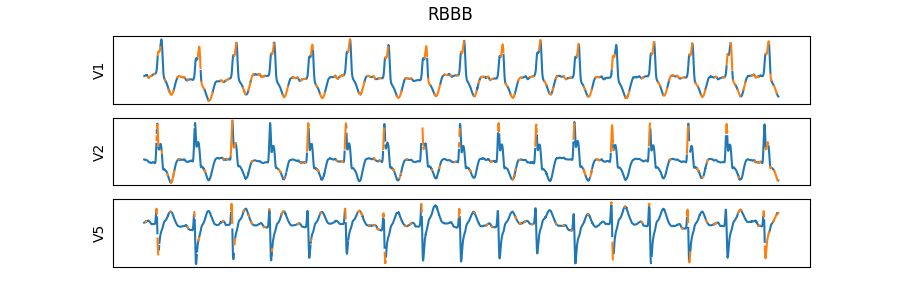

In [2]:
Image(filename="[110]\shap\shap1-A0001.png")

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Artvl\AppData\Local\Temp\ipykernel_8504\1914693615.py:1: SyntaxWarning: invalid escape sequence '\s'
  Image(filename="[110]\shap\shap1-A0002.png")


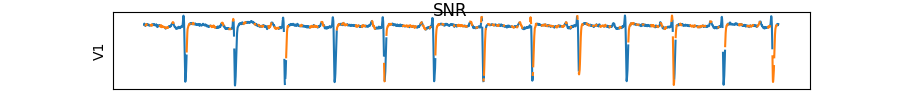

In [3]:
Image(filename="[110]\shap\shap1-A0002.png")

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Artvl\AppData\Local\Temp\ipykernel_8504\896713080.py:1: SyntaxWarning: invalid escape sequence '\s'
  Image(filename="[110]\shap\shap1-A0003.png")


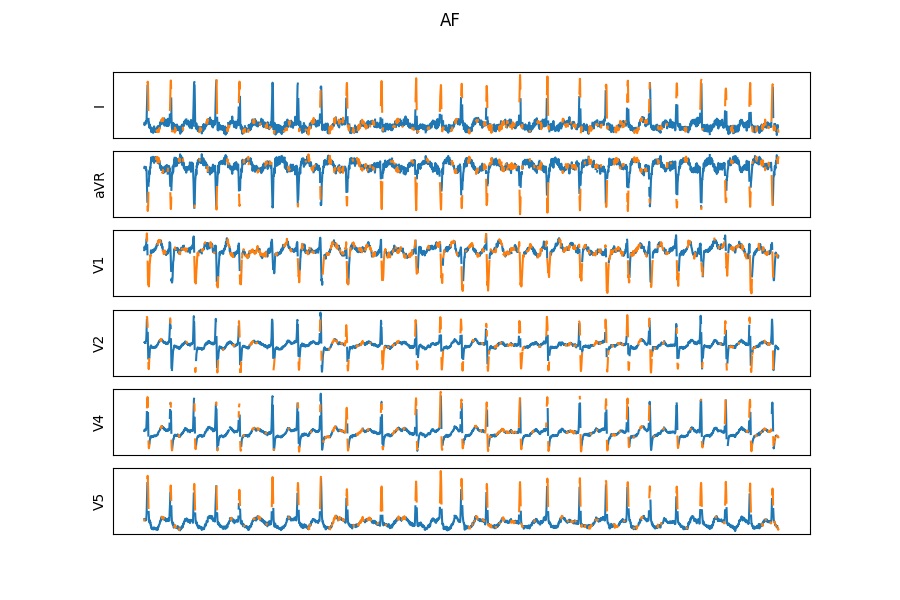

In [4]:
Image(filename="[110]\shap\shap1-A0003.png")

### Summary statistics

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Artvl\AppData\Local\Temp\ipykernel_8504\4285048575.py:1: SyntaxWarning: invalid escape sequence '\s'
  Image(filename="[110]\shap\summary.png")


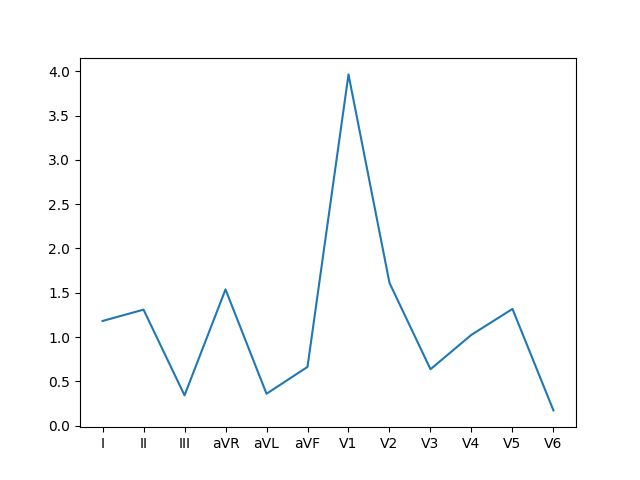

In [5]:
Image(filename="[110]\shap\summary.png")

In [ ]:
# statistic.py


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--data-dir', type=str, default='/kaggle/input/ecg-diagnosis/data/CPSC', help='Directory to dataset')
    args = Args()

    classes = ['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE']
    df_labels = pd.read_csv(os.path.join(args.data_dir, 'labels.csv'))
    df_reference = pd.read_csv(os.path.join(args.data_dir, 'reference.csv'))

    df = pd.merge(df_labels, df_reference[['patient_id', 'age', 'sex', 'signal_len']], on='patient_id', how='left')
    df['sex'] = (df['sex'] == 'Male').astype(int)
    df['signal_len'] = df['signal_len'] / 500

    N = len(df)

    results = []

    for col in classes:
        result = []
        df_tmp = df[df[col] == 1]
        result.append('%d (%.2f)' % (len(df_tmp), len(df_tmp) * 100 / N)) # count
        result.append('%d (%.2f)' % (df_tmp['sex'].sum(), df_tmp['sex'].mean() * 100)) # count and percentage of males
        result.append('%.2f (%.2f)' % (df_tmp['age'].mean(), df_tmp['age'].std())) # mean and std age
        result.append('%.2f (%.2f)' % (df_tmp['signal_len'].mean(), df_tmp['signal_len'].std())) # mean and std length
        results.append(result)

    df_stat = pd.DataFrame(results, index=classes, columns=['N', 'Male (%)', 'Age', 'Signal length'])
    print(df_stat) # the statistics is different from official, may because they only use first label

                 N      Male (%)            Age  Signal length
SNR    918 (13.35)   363 (39.54)  41.56 (18.45)   15.43 (7.64)
AF    1221 (17.75)   692 (56.67)  71.47 (12.53)   15.07 (8.73)
IAVB   722 (10.50)   490 (67.87)  66.97 (15.67)   14.42 (7.08)
LBBB    236 (3.43)   117 (49.58)  70.48 (12.55)   15.10 (8.10)
RBBB  1858 (27.01)  1204 (64.80)  62.84 (17.06)   14.73 (9.00)
PAC     616 (8.96)   328 (53.25)  66.56 (17.71)  19.30 (12.39)
PVC    700 (10.18)   357 (51.00)  58.37 (17.90)  20.84 (15.39)
STD    869 (12.63)   252 (29.00)  54.61 (17.49)   15.65 (9.79)
STE     220 (3.20)   180 (81.82)  52.32 (19.77)  17.31 (10.74)


In [ ]:
# visualise.py


class Args:
    data_dir = "/kaggle/input/ecg-diagnosis/data/CPSC"
    leads = "all"
    use_gpu = True
    model_path = ''  # Или укажите путь к уже обученной модели
    seed = 42
    batch_size = 32
    num_workers = 4
    lr = 0.001
    epochs = 40
    resume = False  # Если хотите загрузить модель из model_path, установите в True
    phase = "train"  # Или 'test' для тестирования
    record_paths = "/kaggle/input/ecg-diagnosis/data/CPSC/A0010.mat"


def plot_ecg(leads, data, title):
    n_cols = 1
    n_rows = len(leads) // n_cols
    f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 16))
    for i in range(n_rows):
        axs[i].plot(data[i])
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_ylabel(leads[i])
        yabs_max = abs(max(axs[i].get_ylim(), key=abs))
        axs[i].set_ylim(ymin=-yabs_max, ymax=yabs_max)
    plt.savefig(f'/kaggle/working/{title}.png')
    plt.close(f)


def plot_ecg2(leads, data, title):
    n_cols=2
    n_rows = len(leads) // n_cols
    f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))
    for j in range(n_rows):
        for i in range(n_cols):
            axs[j, i].plot(data[i * n_rows + j])
            axs[j, i].spines['top'].set_visible(False)
            axs[j, i].spines['right'].set_visible(False)
            axs[j, i].set_xticks([])
            axs[j, i].set_yticks([])
            axs[j, i].set_ylabel(leads[i * n_rows + j])
            yabs_max = abs(max(axs[j, i].get_ylim(), key=abs))
            axs[j, i].set_ylim(ymin=-yabs_max, ymax=yabs_max)
    plt.savefig(f'/kaggle/working/{title}-c2.png')
    plt.close(f)


if __name__ == "__main__":
    args = Args()
    recordpaths = glob(args.record_paths)
    for mat_file in tqdm(recordpaths):
        if mat_file.endswith('.mat') or mat_file.endswith('.hea'):
            mat_file = mat_file[:-4]
        patient_id = os.path.basename(mat_file)
        ecg_data, meta_data = wfdb.rdsamp(mat_file)
        leads = meta_data['sig_name']
        plot_ecg(leads=leads, data=ecg_data.T, title=os.path.basename(mat_file))
        plot_ecg2(leads=leads, data=ecg_data.T, title=os.path.basename(mat_file))

100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


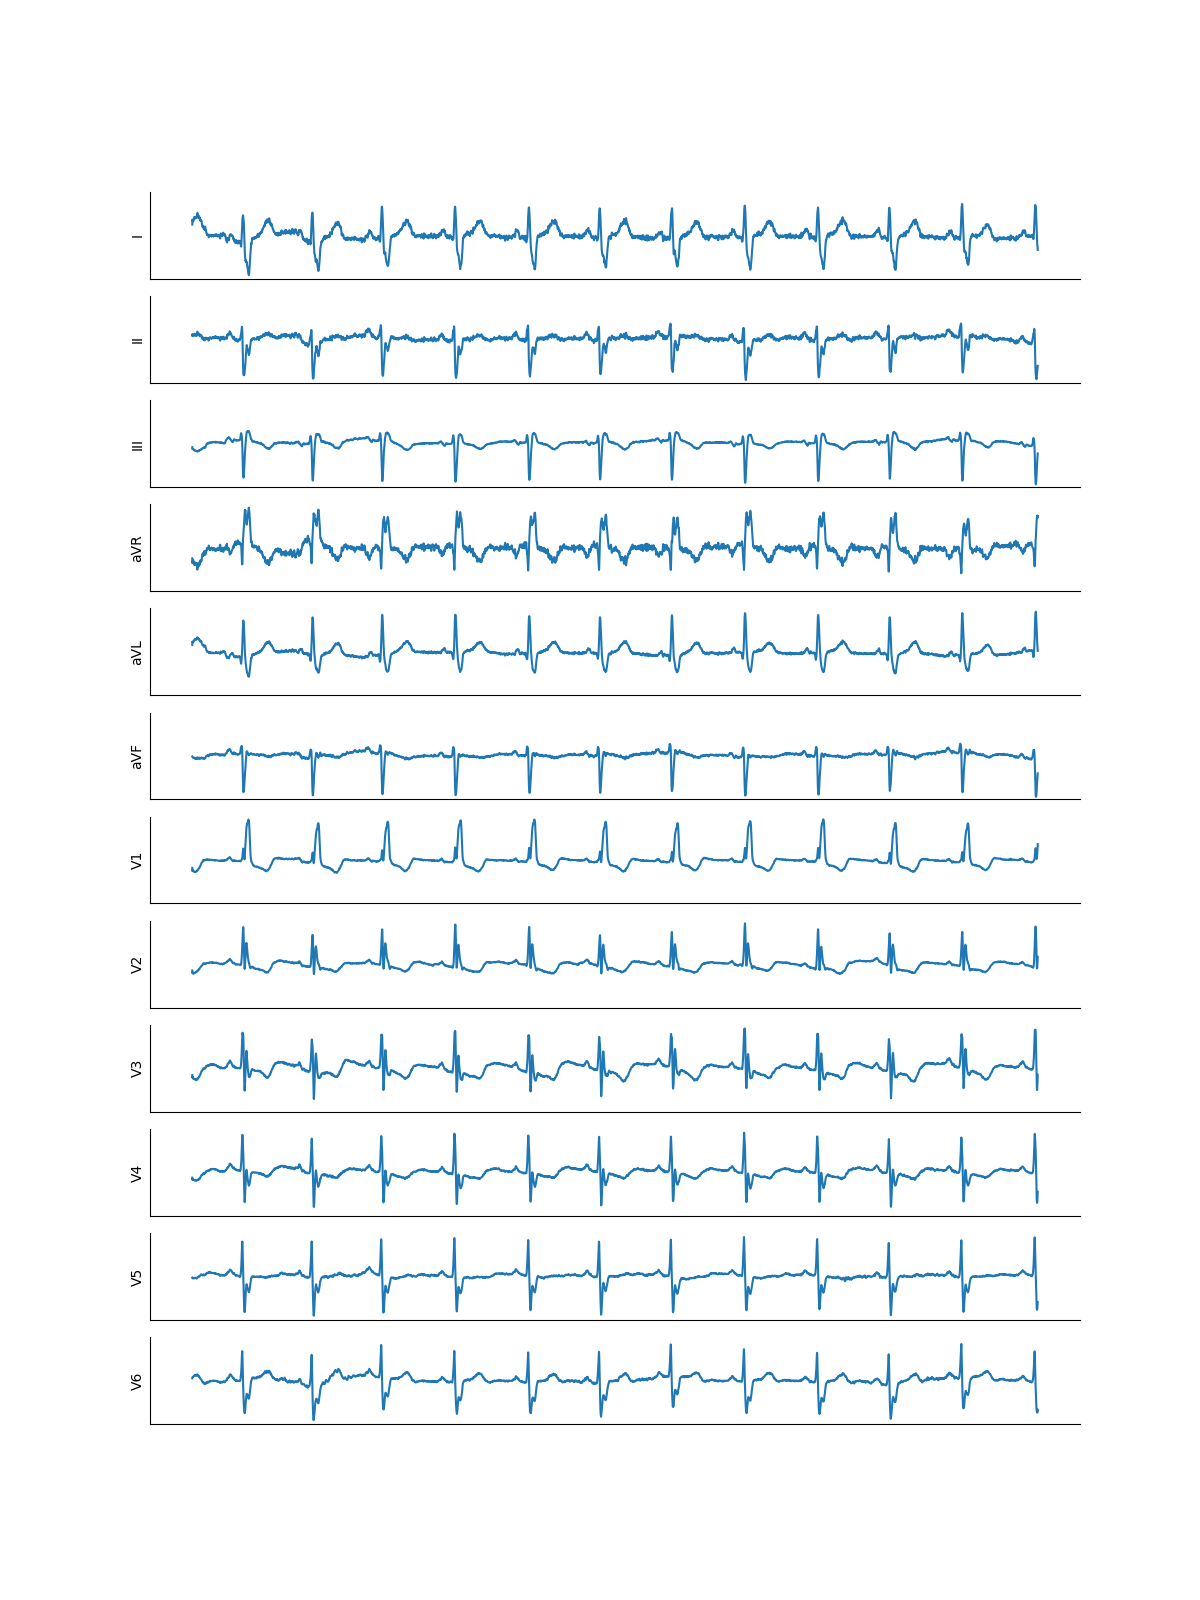

In [39]:
Image(filename='/kaggle/working/A0010.png')

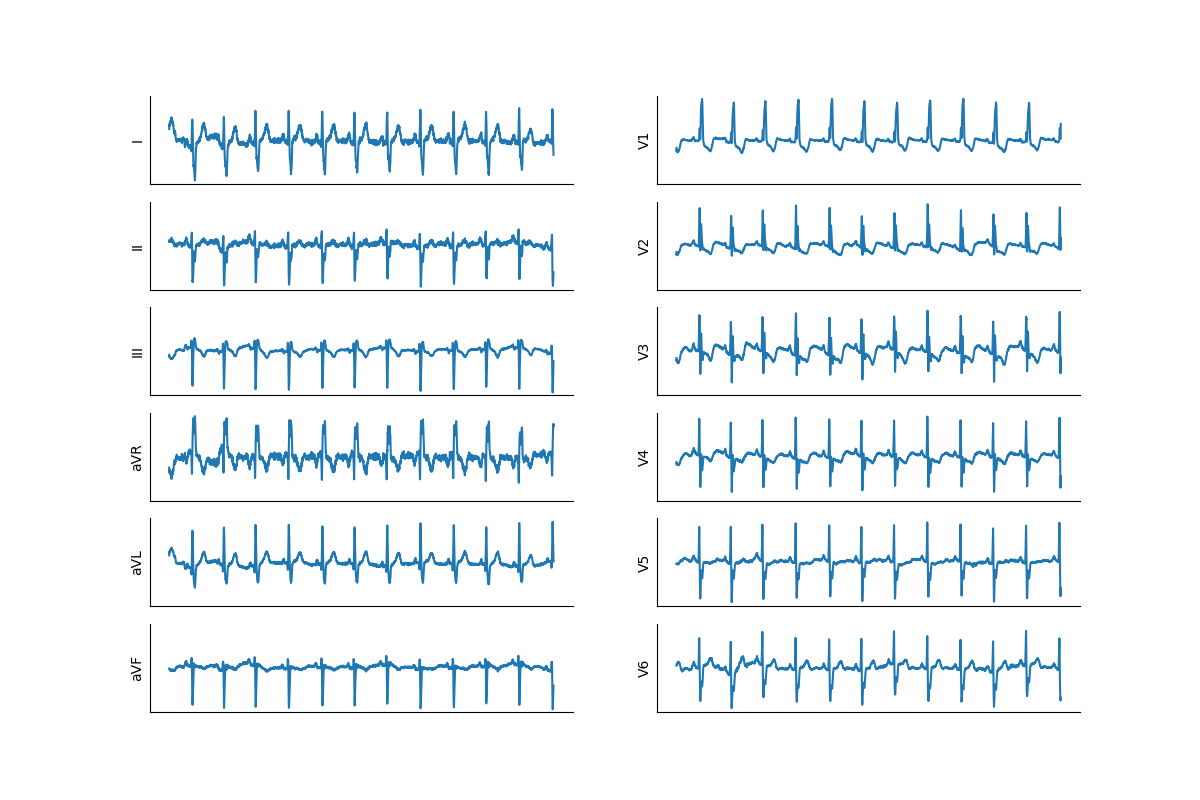

In [40]:
Image(filename='/kaggle/working/A0010-c2.png')